### **Statistical ML and DL**

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 9 12:13:00 2022

@author: Bradley

Code for the Deep Learning Book: Statistical ML and DL (to be published by Phillip YAM from CUHK)
"""

'\nCreated on Wed Mar 9 12:13:00 2022\n\n@author: Bradley\n\nCode for the Deep Learning Book: Statistical ML and DL\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' 

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### **Numerical Optimization Methods**

#### **gradient descent**

$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{w} + b + \epsilon
$$

GD with one dimension

In [3]:
def gradient_descent(x, y, eta=1e-3, epochs=1e5):
    omega_t, b_t = 0,0
    for epoch in range(int(epochs)):
        # calculate gradient
        dw = np.mean(-x*(y-omega_t*x-b_t))
        db = np.mean(-(y-omega_t*x-b_t))

        # update coefficients
        omega_t = omega_t - dw*eta
        b_t = b_t - db*eta
    return({"omega": omega_t, "b": b_t})

In [5]:
data = pd.read_csv("./data/Advertising.csv")
# 只取两列演示一维度的下降
x, y = data['TV'].values, data['sales'].values
gradient_descent(x, y, eta=1e-3, epochs=1e5)
gradient_descent(x, y, eta=6e-5, epochs=1e6)

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x.reshape(-1,1), y) #变成column vector再操作
print({"omega": model.coef_[0], "b":model.intercept_})

{'omega': nan, 'b': nan}

{'omega': 0.04753664940393587, 'b': 7.032591782591389}

{'omega': 0.04753664043301976, 'b': 7.032593549127694}


#### **Newton-Raphson Method**

Multiple Linear Regressions

In [ ]:
# calculate the gradient and hessian for the linear function
# should differ case by case
def Gradient(X, y, theta):
    return -2 * X.T @ (y - X @ theta) / len(y)

def Hessian(X, y, theta):
    return 2 * X.T @ X / len(y)

def Error_Gradient(X, y, theta):
    return -X

In [ ]:
def Newton(X, y, epochs=1e3, tol=1e-8):
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        # add a column of ones into X
        intercept = np.ones(len(X)).reshape(-1,1)
        X, y = np.hstack((intercept, X)), np.array(y)
        # initialize a column of 1 as the intercept for the regression
        theta_t = np.zeros(np.shape(X)[1])
        for epoch in range(int(epochs)):
            dg = Gradient(X, y, theta_t)
            dH = Hessian(X, y, theta_t)

            theta_new = theta_t - np.linalg.inv(dH) @ dg
            delta = theta_new - theta_t
            theta_t = theta_new
            # if the norm of the difference is smaller than the threshold
            if sum(delta**2) < tol**2:
                return ({"Method": "Newton-Raphson", "nsteps": epoch+1, "b": theta_t[0], "omega": theta_t[1:]})
    return ({"Method": "Newton-Raphson", "nsteps": epoch+1, "b": theta_t[0], "omega": theta_t[1:]})

In [ ]:
data = pd.read_csv("./data/Advertising.csv", index_col=0)
X, y = data.drop(columns="sales").values, data["sales"].values

print(Newton(X, y))


from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X, y)
print({"omega": model.coef_, "b":model.intercept_})

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


#### **SGD, Adagrad, RMSprop, Momentum, Adam**

In [7]:
# dg为gradient
class GD():
    def __init__(self, eta=1e-3):
        self.eta = eta

    def Delta(self, dg):
        return -self.eta * dg


class Adagrad():
    def __init__(self, eta=1e-3, epsilon=1e-8):
        self.eta = eta
        self.epsilon = epsilon
        self.past_g = 0

    def Delta(self, dg):
        self.past_g += dg**2
        inv_G = np.diag((self.past_g**(1/2)+self.epsilon)**(-1))
        return -self.eta * inv_G @ dg

class RMSprop():
    def __init__(self, eta=1e-3, gamma = 0.9, epsilon=1e-8):
        self.eta = eta
        self.gamma = gamma
        self.epsilon = epsilon
        self.v = 0

    def Delta(self, dg):
        self.v = self.gamma * self.v + (1-self.gamma)*dg*dg
        inv_V = np.diag((self.v**(1/2)+self.epsilon)**(-1))
        return -self.eta * inv_V @ dg


class Momentum():
    def __init__(self, eta=1e-3, gamma = 0.9):
        self.eta = eta
        self.gamma = gamma
        self.m = 0

    def Delta(self, dg):
        self.m = self.gamma*self.m - (1-self.gamma)*dg
        return self.eta * self.m

class Adam():
    def __init__(self, eta=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m, self.v = 0,0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
        self.t = 0

    def Delta(self, dg):
        self.t += 1
        self.m = self.beta1*self.m - (1-self.beta1)*dg
        self.v = self.beta2*self.v + (1-self.beta2)*dg**2
        hat_m = self.m/(1-self.beta1**self.t)
        hat_v = self.v/(1-self.beta2**self.t)
        inv_hat_V = np.diag((hat_v**(1/2) + self.epsilon)**(-1))
        return self.eta * inv_hat_V @ hat_m

In [8]:
def Gradient(X, y, theta):
    return -X.T @ (y - X @ theta) / len(y)

def gradient_descent(X, y, optimizer, epochs=1e5):
    intercept = np.ones(len(X)).reshape(-1,1)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
        X, y = np.hstack((intercept, X)), np.array(y)
        theta_t = np.zeros(np.shape(X)[1])
        for epoch in range(int(epochs)):
            # calculate gradient
            dg = Gradient(X, y, theta_t)
            theta_t += optimizer.Delta(dg)

        return({"Optimizer": optimizer.__class__.__name__, "omega": np.squeeze(theta_t[1:]), "b": theta_t[0]})

In [9]:
data = pd.read_csv("./data/Advertising.csv", index_col=0)
X, y = data["TV"].values, data["sales"].values

# 不同的优化算法的参数不同
print(gradient_descent(X, y, GD(eta=1e-5), epochs=1e6))
print(gradient_descent(X, y, Adagrad(eta=1), epochs=1e4))
print(gradient_descent(X, y, RMSprop(eta=1e-4), epochs=1e5))
print(gradient_descent(X, y, Momentum(eta=1e-4), epochs=2e5))
print(gradient_descent(X, y, Adam(eta=1), epochs=1e3))

{'Optimizer': 'GD', 'omega': array(0.05037336), 'b': 6.473992301715564}
{'Optimizer': 'Adagrad', 'omega': array(0.04753664), 'b': 7.032593464887523}
{'Optimizer': 'RMSprop', 'omega': array(0.04748664), 'b': 7.032543549195242}
{'Optimizer': 'Momentum', 'omega': array(0.04776175), 'b': 6.988264681976377}
{'Optimizer': 'Adam', 'omega': array(0.04753664), 'b': 7.0325935491277045}


In [151]:
Beale = lambda x, y: (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2

def Beale_Gradient(theta):
    x, y = theta
    dx = -12.75 + 3*y + 4.5*y**2 + 5.25*y**3 + 2*x*(3-2*y-y**2-2*y**3+y**4+y**6)
    dy = 6*x*(0.5+1.5*y+2.625*y**2+x*(-1/3-1/3*y-y**2+2/3*y**3+y**5))
    return np.array([dx, dy])

def Beale_Gradient_Descent(theta_t, optimizer, max_epochs=1e5, tol=1e-5):
    paths = [theta_t]
    for epoch in range(int(max_epochs)):
        dg = Beale_Gradient(theta_t)
        theta_new = theta_t+optimizer.Delta(dg)
        paths.append(theta_new)
        if sum((theta_new-theta_t)**2) < tol**2:
            return (np.squeeze(paths))
        theta_t = theta_new
    return (np.squeeze(paths))

start = np.array([1,1])
start_ = start.reshape(-1,1)

GD_path = Beale_Gradient_Descent(start, GD(eta=1e-2))
Adagrad_path = Beale_Gradient_Descent(start, Adagrad(eta=1))
RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-3))
Momentum_path = Beale_Gradient_Descent(start, Momentum(eta=1e-1))
Adam_path = Beale_Gradient_Descent(start, Adam(eta=1))

print({'GD': len(GD_path)})
print({'Adagrad': len(Adagrad_path)})
print({'RMSprop': len(RMSprop_path)})
print({'Momentum': len(Momentum_path)})
print({'Adam': len(Adam_path)})

print({"nstep": len(RMSprop_path), "eta": 1e-2, "RMSprop": RMSprop_path[-1]})

{'GD': 1562}
{'Adagrad': 198}
{'RMSprop': 100001}
{'Momentum': 196}
{'Adam': 210}
{'nstep': 100001, 'eta': 0.01, 'RMSprop': array([3.00047138, 0.49949234])}


In [169]:
print({"nstep": len(RMSprop_path), "eta": 1e-2, "RMSprop": RMSprop_path[-1]})
RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1e-1))
print({"nstep": len(RMSprop_path), "eta": 1e-1, "RMSprop": RMSprop_path[-1]})
# RMSprop_path = Beale_Gradient_Descent(start, RMSprop(eta=1))
# print({"nstep": len(RMSprop_path), "eta": 1, "RMSprop": RMSprop_path[-1]})

{'nstep': 100001, 'eta': 0.01, 'RMSprop': array([3.00047138, 0.49949234])}
{'nstep': 100001, 'eta': 0.1, 'RMSprop': array([2.77375513, 0.49763707])}


In [148]:
x1_con = np.linspace(-2,4,1000)
x2_con = np.linspace(-2,4,1000)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
Beale(x1_mes,x2_mes)

array([[  495.703125  ,   493.071561  ,   490.44713928, ...,
         1418.21740955,  1422.70669614,  1427.203125  ],
       [  489.25811645,   486.66348265,   484.07588526, ...,
         1396.02252819,  1400.44318416,  1404.87087653],
       [  482.89546918,   480.33728329,   477.78602933, ...,
         1374.13193987,  1378.48489415,  1382.84478036],
       ...,
       [15718.50853811, 15621.91227922, 15525.61382866, ...,
        67275.66049786, 67475.97914273, 67676.59559592],
       [15864.54973777, 15767.06724979, 15669.88526693, ...,
        67877.10307447, 68079.2241886 , 68281.64580785],
       [16011.703125  , 15913.32770904, 15815.25551523, ...,
        68483.0257855 , 68686.96284418, 68891.203125  ]])

In [158]:
import scipy
outcome = scipy.optimize.minimize(lambda x: (1.5-x[0]+x[0]*x[1])**2 + (2.25-x[0]+x[0]*x[1]**2)**2 + (2.625-x[0]+x[0]*x[1]**3)**2, x0=np.array([1,1]))
outcome

      fun: 1.991104635533182e-14
 hess_inv: array([[3.12703719, 0.7743573 ],
       [0.7743573 , 0.21375943]])
      jac: array([ 3.5033705e-08, -1.2947278e-07])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 15
     njev: 17
   status: 0
  success: True
        x: array([2.99999967, 0.49999991])

In [159]:
outcome.x

array([2.99999967, 0.49999991])

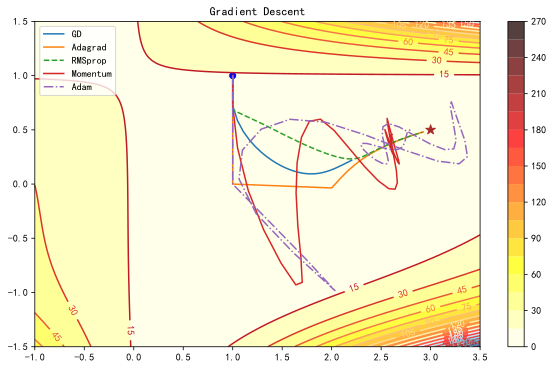

In [170]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
plt.figure(figsize=(10,6))


path = GD_path
x_path, y_path = path[:,0][:50], path[:,1][:50]
plt.plot(x_path, y_path, label='GD')

path = Adagrad_path
x_path, y_path = path[:,0][:50], path[:,1][:50]
plt.plot(x_path, y_path, label='Adagrad', linestyle='-')

path = RMSprop_path
x_path, y_path = path[:,0][:50], path[:,1][:50]
plt.plot(x_path, y_path, label='RMSprop', linestyle='--')

path = Momentum_path
x_path, y_path = path[:,0][:50], path[:,1][:50]
plt.plot(x_path, y_path, label='Momentum')

path = Adam_path
x_path, y_path = path[:,0][:50], path[:,1][:50]
plt.plot(x_path, y_path, label='Adam', linestyle='-.')
# plt.xlim((-1,4))
# plt.ylim((-1,3))
plt.legend(loc='upper left')


plt.title('Gradient Descent')
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
# plt.plot(x1_mes, x2_mes)
cset = plt.contourf(x1_mes,x2_mes,y_con, levels=20, alpha=.75, cmap='hot_r')
plt.colorbar(cset)
C = plt.contour(x1_mes,x2_mes,y_con, levels=20, camp='RdYlBu') #contour依次传入x1，x2，y就可以产生等值云图
plt.clabel(C, inline=True, fontsize=10)


plt.scatter(1, 1, marker="8", color="b", s=40)
plt.scatter(3, 0.5, marker="*", color="brown", s=100)
plt.savefig("./gradient_descent.png", dpi=1000)
plt.show()

No handles with labels found to put in legend.


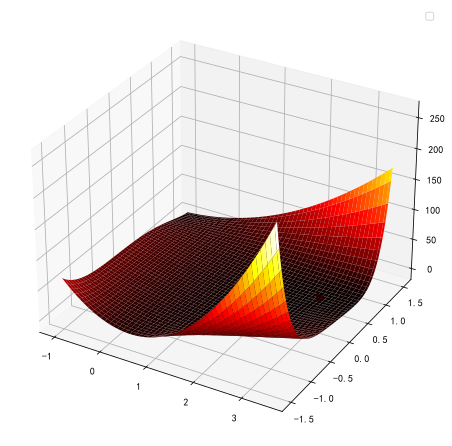

In [162]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
x1_con = np.linspace(-1,3.5,100)
x2_con = np.linspace(-1.5,1.5,100)
x1_mes, x2_mes = np.meshgrid(x1_con,x2_con)
y_con = Beale(x1_mes,x2_mes)
fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
ax.plot_surface(x1_mes,x2_mes,y_con, cmap='hot')
ax.scatter(x_path[-1],y_path[-1], Beale(x_path[-1],y_path[-1]), s=50, c='red')
ax.legend()

#### **Mini-Batch SGD**

In [163]:
import time
from sklearn.utils import shuffle
np.random.seed(4012)
N = 100
x = np.linspace(-1, 1, N)
y = 2*x + 5 + np.random.randn(N)/100
x, y = shuffle(x, y, random_state=4012)
def gradient(x, y, w, b):
    return -x*(y-(w*x+b)), -(y-(w*x+b))

In [166]:
# SGD algorithm
def SGD(inits, X, y, lr=1e-3, n_iter=10000, eta=1e-12):
    w, b = inits
    w_list, b_list = [w], [b] 
    for i in range(n_iter):
        for j in range(len(y)):
            grad_w, grad_b = gradient(X[j], y[j], w, b)
            w -= lr*grad_w
            b -= lr*grad_b
            w_list.append(w)
            b_list.append(b)
            if (w-w_list[-2])**2 + (b-b_list[-2])**2 < eta:
                return w_list, b_list
    return w_list, b_list

start_time = time.time()
SGD_w, SGD_b = SGD([-4, 0], x, y, lr=0.02, eta=1e-8)
SGD_time = time.time() - start_time
print({"Method": "SGD with eta=1e-8", "niter": len(SGD_w), "time": SGD_time, "w": SGD_w[-1], "b":SGD_b[-1]})


start_time = time.time()
SGD_w, SGD_b = SGD([-4, 0], x, y, lr=0.02, eta=1e-12)
SGD_time = time.time() - start_time
print({"Method": "SGD with eta=1e-12", "niter": len(SGD_w), "time": SGD_time, "w": SGD_w[-1], "b":SGD_b[-1]})

{'Method': 'SGD with eta=1e-8', 'niter': 143, 'time': 0.0, 'w': -0.10244944370777345, 'b': 4.976970857873605}
{'Method': 'SGD with eta=1e-12', 'niter': 991, 'time': 0.0020067691802978516, 'w': 1.9955364985358999, 'b': 5.000478973363515}


In [172]:
# mini-batch SGD
# bs: batch size
def MbSGD(inits, X, y, lr=1e-3, n_iter=10000, bs=32, eta=1e-8):
    ind = np.arange(len(y))
    w, b = inits
    w_list, b_list = [w], [b]
    batch_indices = [ind[i:(i+bs)] for i in range(0, len(y), bs)] 
    for i in range(n_iter):
        for indices in batch_indices:
            grad_sum_w, grad_sum_b = 0, 0
            for j in indices:
                grad_w, grad_b = gradient(X[j], y[j], w, b)
                grad_sum_w += grad_w
                grad_sum_b += grad_b
            w -= lr*grad_sum_w/len(indices)
            b -= lr*grad_sum_b/len(indices)
            w_list.append(w)
            b_list.append(b)
            if (w-w_list[-2])**2 + (b-b_list[-2])**2 < eta:
                return w_list, b_list
    return w_list, b_list


start_time = time.time()
MbSGD_w, MbSGD_b = MbSGD([-4, 0], x, y, lr=0.02, eta=1e-8)
MbSGD_time = time.time() - start_time
print({"Method": "Mini-batch SGD with eta=1e-8", "niter": len(MbSGD_w), "time": MbSGD_time, "w": MbSGD_w[-1], "b":MbSGD_b[-1]})

start_time = time.time()
MbSGD_w, MbSGD_b = MbSGD([-4, 0], x, y, lr=0.02, eta=1e-12)
MbSGD_time = time.time() - start_time
print({"Method": "Mini-batch SGD with eta=1e-12", "niter": len(MbSGD_w), "time": MbSGD_time, "w": MbSGD_w[-1], "b":MbSGD_b[-1]})

{'Method': 'Mini-batch SGD with eta=1e-8', 'niter': 857, 'time': 0.029063701629638672, 'w': 1.9886699053277366, 'b': 5.001721600322803}
{'Method': 'Mini-batch SGD with eta=1e-12', 'niter': 40001, 'time': 1.0390770435333252, 'w': 2.00170557936738, 'b': 5.001104101875624}


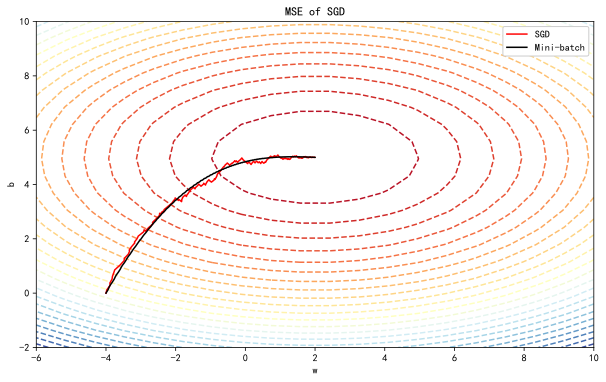

In [177]:
w = np.linspace(-6, 10, 20)
b = np.linspace(-2, 10, 20)
Wgrid, Bgrid = np.meshgrid(w, b)
MSE = 0
for xs, ys in zip(x, y):
    MSE += (ys-(Wgrid*xs+Bgrid))**2/N/2

plt.figure(figsize=(10, 6))
cp = plt.contour(Wgrid, Bgrid, MSE, levels=25, linestyles="dashed")
plt.xlabel('w')
plt.ylabel('b')
plt.title("MSE of SGD")
plt.plot(SGD_w, SGD_b, color='r', label='SGD')
plt.plot(MbSGD_w, MbSGD_b, color="black", label = "Mini-batch")
plt.legend(framealpha=1, frameon=True)
plt.savefig("./figures/SGD_vs_Minibatch.png", dpi=1000)
plt.show()

**use array to improve the efficiency of Mini-batch SGD**

In [178]:
def MbSGD_Mat(inits, X, y, lr=1e-3, n_iter=10000, bs=32, eta=1e-8):
    ind = np.arange(len(y))
    w, b = inits
    w_list, b_list = [w], [b]
    batch_indices = [ind[i:(i+bs)] for i in range(0, len(y), bs)] 
    for _ in range(n_iter):
        for indices in batch_indices:
            grad_w, grad_b = gradient(X[indices], y[indices], w, b)
            w -= lr*np.mean(grad_w)
            b -= lr*np.mean(grad_b)
            w_list.append(w)
            b_list.append(b)
            if (w-w_list[-2])**2 + (b-b_list[-2])**2 < eta:
                return w_list, b_list
    return w_list, b_list


start_time = time.time()
MbSGD_w, MbSGD_b = MbSGD([-4, 0], x, y, lr=0.02, eta=1e-8)
MbSGD_time = time.time() - start_time
print({"Method": "Mini-batch SGD with eta=1e-8", "niter": len(MbSGD_w), "time": MbSGD_time, "w": MbSGD_w[-1], "b":MbSGD_b[-1]})

{'Method': 'Mini-batch SGD with eta=1e-8', 'niter': 857, 'time': 0.025000810623168945, 'w': 1.9886699053277366, 'b': 5.001721600322803}
